# Clustring Entertainment News

## Work FLow

### 1. Introduction and Problem Description
### 2. Data Collection from existing datasets
### 3. Data Preparation and Cleaning using pandas and NLTK
### 4. Model Training using sklearn and kmeans
### 5. Web Scraping for Model Evaluation using beautifulsoup
### 6. Model Deployment using flask and docker

# 1. Introduction and Problem Description

As we all know that in deecoob MESLIS collects data on music events and venues to rank them for further evaluation. In this notebook I have made an attempt to cluster important news articles related to new music events and concerts that can be important to MESLIS from the overall entertainment news section.

# 2. Data Collection from existing Datasets

Music related news regarding concerts and events is mainly in the entertainment section of the news sites. I found existing datasets of news articles and extracted only the entertainment section for our usecase.

#### 1st dataset is news category dataset from the year 2012 to 2018 obtained from HuffPost - 
#### 2nd dataset is BBC News Archive dataset from year 2004-2005 
#### 3rd dataset is from MachineHack Hackathon from the year 2019
#### 4th dataset is cra from firstpost and ndtv from year 2020

In [42]:
import pandas as pd

#HuffPost Extracting content only for category Entertainment
df_dataset1 = pd.read_json('data/News_Category_Dataset_v2.json',lines=True)
df_dataset1.drop(['authors','link','date'],axis=1,inplace=True)
df_dataset1['text'] = df_dataset1['headline'] + df_dataset1['short_description']
df_dataset1.drop(['short_description','headline'],axis=1,inplace=True)
df_dataset1 = df_dataset1[df_dataset1["category"].str.contains("ENTERTAINMENT")==True]
df_dataset1 = df_dataset1.drop(['category'],axis=1,inplace=False)

#BBC News Archive Extracting content only for category Entertainment
df_dataset2 = pd.read_csv('data/bbc-news-data.csv',sep='\t')
df_dataset2.drop(['filename'],axis=1,inplace=True)
df_dataset2['text'] = df_dataset2['title'] + df_dataset2['content']
df_dataset2.drop(['content'],axis=1,inplace=True)
df_dataset2 = df_dataset2[df_dataset2["category"].str.contains("entertainment")==True]
df_dataset2 = df_dataset2.drop(['category',"title"],axis=1,inplace=False)

#MachineHack Extracting content only for category Entertainment
df_dataset3 = pd.read_csv('data/Data_Train.csv',encoding='cp1252')
df_dataset3['text'] = df_dataset3['STORY']
df_dataset3.drop(['STORY'],axis=1,inplace=True)
df_dataset3['SECTION']=df_dataset3['SECTION'].apply(str)
df_dataset3 = df_dataset3[df_dataset3["SECTION"].str.contains("2")==True]
df_dataset3 = df_dataset3.drop(['SECTION'],axis=1,inplace=False)
df_dataset3['text']=df_dataset3['text'].apply(str)

#firstpost ndtv Extracting content only for category Entertainment
df_dataset4 = pd.read_csv('data/historic_articles.csv')
df_dataset4['text'] =  df_dataset4['header'] + df_dataset4['content']
df_dataset4.drop(["source","link","author","published_at","header","subheader","content"],axis=1,inplace=True)
df_dataset4 = df_dataset4[df_dataset4["category"].str.contains("entertainment")==True]
df_dataset4 = df_dataset4.drop(['category'],axis=1,inplace=False)

print("dataset1 Count", df_dataset1.count())
print("dataset2 Count", df_dataset2.count())
print("dataset3 Count", df_dataset3.count())
print("dataset4 Count", df_dataset4.count())


dataset1 Count text    16058
dtype: int64
dataset2 Count text    386
dtype: int64
dataset3 Count text    1924
dtype: int64
dataset4 Count text    442
dtype: int64


In [43]:
# Combining all data sets into one data set and saving it for further use

frames = [df_dataset1,df_dataset2,df_dataset3,df_dataset4]

df_final_dataset = pd.concat(frames,ignore_index=True)
df_final_dataset = df_final_dataset.reset_index()
df_final_dataset = df_final_dataset.dropna() #Droping empty Columns
df_final_dataset.to_csv('data/combined_entertaiment_dataset.csv') # Saving to CSV
print(df_final_dataset.count())

index    18810
text     18810
dtype: int64


# 3. Data Preparation and Cleaning using pandas and NLTK

Before training our model we will clean the text by removing the stopwords, links and special characters.
For this task we will use NLTK Library

In [7]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

df_entertainment_news = pd.read_csv('data/combined_entertaiment_dataset.csv')

# Removing Duplicates
df_entertainment_news = df_entertainment_news.drop_duplicates('text')
print(df_entertainment_news.count())

def cleaned_text(text: str, remove_stopwords: bool) -> str:
    """This utility function sanitizes a string by:
    - removing links
    - removing special characters
    - removing numbers
    - removing stopwords
    - transforming in lowercase
    - removing excessive whitespaces
    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords
    Returns:
        str: the cleaned text
    """

    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    if remove_stopwords:
        # 1. tokenize
        tokens = nltk.word_tokenize(text)
        # 2. check if stopword
        tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
        # 3. join back together
        text = " ".join(tokens)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

df_entertainment_news['text']=df_entertainment_news['text'].apply(str)
df_entertainment_news['cleaned'] = df_entertainment_news['text'].apply(lambda x: cleaned_text(x, remove_stopwords=True))
df_entertainment_news.to_csv('data/combined_entertaiment_dataset_cleaned.csv')

Unnamed: 0    18779
index         18779
text          18779
dtype: int64


# 4. Model Training using sklearn and kmeans

First we use Tfidf to find the important word and then vectorize them. Then we plot the elbow curve so that we can decide on the number of clusters that we will choose

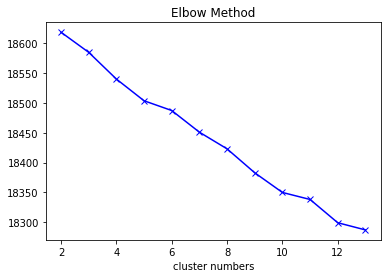

In [11]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

df_entertainment_news = pd.read_csv('data/combined_entertaiment_dataset_cleaned.csv')

# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)

# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df_entertainment_news['cleaned'])

K = range(2, 14)
SSE = []
for k in K:
    kmeans_model = KMeans(n_clusters=k)
    kmeans_model.fit(X)
    SSE.append(kmeans_model.inertia_)

import matplotlib.pyplot as plt

plt.plot(K, SSE, 'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()


Based on the elbow curve we cannot decide for certain how many number of clusters should we choose. This is because the features are really close to each other and overlap. However we see a lower slop on clusters 5 and 6 and then on 12 and 13. Lets test slopes 5 and 6 and see if the clusters are well defined


Cluster 0
orange,swift,documentary,taylor,love,wars,like,look,watch,time,back,get,black,film,single,one,first,netflix,show,year,season,video,star,song,movie,music,york,album,trailer,new


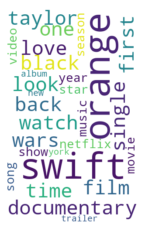


Cluster 1
also,back,republican,twitter,takes,really,think,jimmy,bush,white,america,calls,people,new,one,like,gop,presidential,would,said,stephen,snl,colbert,alec,says,show,baldwin,president,donald,trump


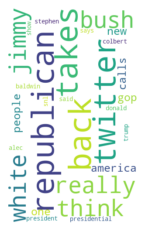


Cluster 2
also,band,best,years,fans,grammy,tour,love,former,adele,performance,one,dead,song,video,taylor,swift,concert,says,old,country,hit,show,new,said,year,songwriter,music,album,singer


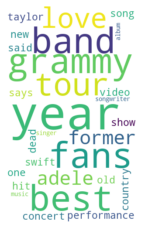


Cluster 3
work,release,years,people,star,shared,made,day,avengers,festival,two,would,last,best,weekend,million,director,time,first,like,movie,films,year,one,actor,said,also,office,box,film


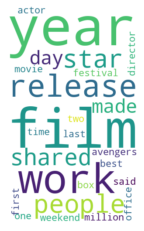


Cluster 4
williams,actor,kit,emilia,battle,might,like,maisie,major,reveal,harington,final,watch,george,arya,one,character,martin,may,show,new,snow,episode,jon,star,coming,hbo,season,game,thrones


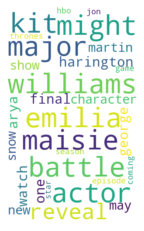


Cluster 5
us,said,night,people,jenner,know,got,dead,make,swift,actor,kim,taylor,music,get,back,best,love,season,year,watch,movie,time,kardashian,one,says,like,show,first,star


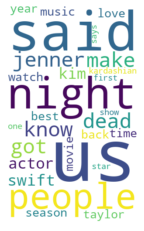

None


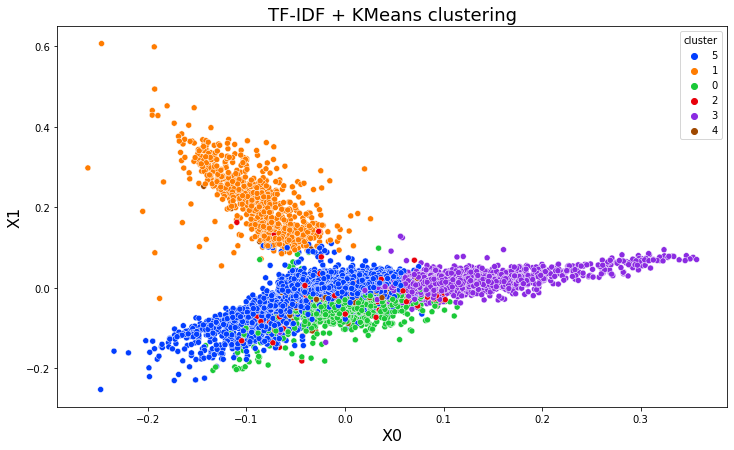

In [8]:
# 6 clusters

import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,IncrementalPCA

df_entertainment_news = pd.read_csv('data/combined_entertaiment_dataset_cleaned.csv')
df_entertainment_news = df_entertainment_news.dropna()
# initialize the vectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df_entertainment_news['cleaned'])

# initialize kmeans_model with 6 centroids
kmeans_model = KMeans(n_clusters=6, random_state=42,algorithm='lloyd')
# fit the model
kmeans_model.fit(X)
# store cluster labels in a variable
clusters = kmeans_model.labels_

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass X to the pca
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

df_entertainment_news['cluster'] = clusters
df_entertainment_news['x0'] = x0
df_entertainment_news['x1'] = x1


def get_top_keywords(n_terms:int):
    """This function prints the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean()  # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out()  # access tf-idf terms
    for i, r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[
                                          -n_terms:]]))  # for each row of the dataframe, find the n terms that have the highest tf idf score
        text = ' '.join([terms[t] for t in np.argsort(r)[
                                    -n_terms:]])
        wc = WordCloud(background_color="white",height=500, width=300)
        wcloud = wc.generate(text)
        plt.imshow(wcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

print(get_top_keywords(30))

cluster_map = {0: "0", 1: "1",2:"2",3:"3", 4: "4",5:"5"}
# apply mapping
df_entertainment_news['cluster'] = df_entertainment_news['cluster'].map(cluster_map)

# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})

# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df_entertainment_news, x='x0', y='x1', hue='cluster', palette="bright")
plt.show()

Cluster 0 Can Be Defined as Awards Music Show and Talk SHow
tv,stone,harassment,two,night,see,amy,awards,actor,fallon,carpet,meryl,nominations,lady,leonardo,dicaprio,time,globesthe,streep,gaga,speech,sexual,winners,hollywood,wins,red,best,globe,globes,golden

Cluster 1 Can be Game Of Thrones
williams,actor,kit,emilia,battle,might,like,maisie,major,reveal,harington,final,watch,george,arya,one,character,martin,may,show,new,snow,episode,jon,star,coming,hbo,season,game,thrones

Cluster 2 Can be  Related to Films
avengers,work,release,people,shared,years,star,day,made,festival,two,would,last,weekend,best,million,director,first,time,like,movie,films,year,actor,one,said,also,office,box,film

Cluster 3 Can be Talk show and Politics
also,back,republican,twitter,takes,really,jimmy,think,bush,white,america,calls,people,new,one,like,gop,presidential,would,said,stephen,snl,colbert,alec,show,says,baldwin,president,donald,trump

Cluster 4 Can be Kardashians and Music
night,said,jenner,make,know,people,got,singer,actor,swift,kim,dead,get,best,taylor,season,back,music,love,watch,year,time,movie,kardashian,one,says,like,show,first,star

Cluster 5 Can be Music and Movies
clip,documentary,love,swift,taylor,wars,time,look,like,watch,back,black,get,film,one,first,single,netflix,show,year,season,star,video,song,movie,music,york,trailer,album,new

### As we can se there is quite an overlap between the music news that we are interested in. Lets see how are the results for 5 clusters









Cluster 0
two,know,world,trailer,day,years,us,season,life,make,watch,people,get,back,also,actor,love,music,best,said,says,time,movie,show,year,like,first,one,film,new


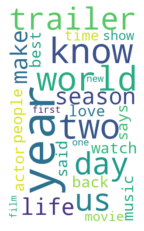


Cluster 1
tv,john,old,character,pop,director,died,season,says,co,former,year,actress,studded,show,first,said,trailer,film,one,awakens,movie,trek,force,actor,new,walking,wars,dead,star


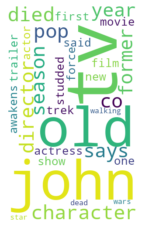


Cluster 2
reportedly,keeping,first,kardashians,adorable,says,kris,shares,scott,north,instagram,odom,star,family,lamar,chyna,pregnant,blac,reality,disick,photo,baby,jenner,rob,west,kanye,kourtney,khloe,kim,kardashian


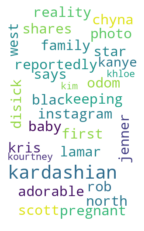


Cluster 3
actor,kit,emilia,williams,battle,might,like,maisie,major,reveal,harington,final,watch,george,arya,one,character,martin,may,show,new,snow,jon,star,episode,coming,hbo,season,game,thrones


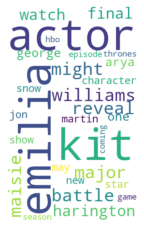


Cluster 4
also,fallon,republican,back,takes,really,think,white,jimmy,bush,america,calls,people,one,gop,like,new,presidential,would,said,stephen,snl,colbert,alec,show,says,baldwin,president,donald,trump


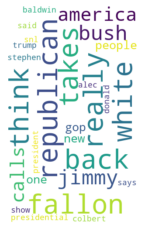

None


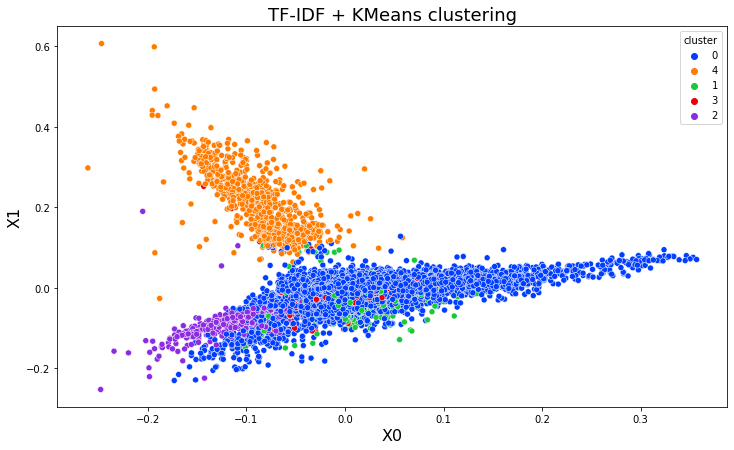

In [15]:
# 5 clusters

import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,IncrementalPCA

df_entertainment_news = pd.read_csv('data/combined_entertaiment_dataset_cleaned.csv')
df_entertainment_news = df_entertainment_news.dropna()
# initialize the vectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df_entertainment_news['cleaned'])

# initialize kmeans_model with 5 centroids
kmeans_model = KMeans(n_clusters=5, random_state=42,algorithm='lloyd')
# fit the model
kmeans_model.fit(X)
# store cluster labels in a variable
clusters = kmeans_model.labels_

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass X to the pca
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

df_entertainment_news['cluster'] = clusters
df_entertainment_news['x0'] = x0
df_entertainment_news['x1'] = x1


def get_top_keywords(n_terms:int):
    """This function prints the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean()  # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out()  # access tf-idf terms
    for i, r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[
                                          -n_terms:]]))  # for each row of the dataframe, find the n terms that have the highest tf idf score
        text = ' '.join([terms[t] for t in np.argsort(r)[
                                    -n_terms:]])
        wc = WordCloud(background_color="white",height=500, width=300)
        wcloud = wc.generate(text)
        plt.imshow(wcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

print(get_top_keywords(30))

cluster_map = {0: "0", 1: "1",2:"2",3:"3", 4: "4"}
# apply mapping
df_entertainment_news['cluster'] = df_entertainment_news['cluster'].map(cluster_map)

# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})

# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df_entertainment_news, x='x0', y='x1', hue='cluster', palette="bright")
plt.show()

Cluster 0 New Music TV Shows Movies
two,know,world,trailer,day,years,us,season,life,make,watch,people,get,back,also,actor,love,music,best,said,says,time,movie,show,year,like,first,one,film,new

Cluster 1 New Movies Music TV Shows
tv,john,old,character,pop,director,died,season,says,co,former,year,actress,studded,show,first,said,trailer,film,one,awakens,movie,trek,force,actor,new,walking,wars,dead,star

Cluster 2 Kardashians
reportedly,keeping,first,kardashians,adorable,says,kris,shares,scott,north,instagram,odom,star,family,lamar,chyna,pregnant,blac,reality,disick,photo,baby,jenner,rob,west,kanye,kourtney,khloe,kim,kardashian

Cluster 3 Game of Thrones
actor,kit,emilia,williams,battle,might,like,maisie,major,reveal,harington,final,watch,george,arya,one,character,martin,may,show,new,snow,jon,star,episode,coming,hbo,season,game,thrones

Cluster 4 Trump Related entertaiment
also,fallon,republican,back,takes,really,think,white,jimmy,bush,america,calls,people,one,gop,like,new,presidential,would,said,stephen,snl,colbert,alec,show,says,baldwin,president,donald,trump

### Looking at these keywords these clusters are well seperated and dont overlap compared to 6 clusters. Here Cluster 0 and 1 are of intrest to us. Rest of the clusters are well defined for Kardashians, Game of Thrones and Trump Related Entertainment

In [16]:
# Saving the Vectorizer and Model
with open("kmeans_trained_model/vectorizer.pkl", 'wb') as handle:
    pickle.dump(vectorizer, handle)
    
with open("kmeans_trained_model/kmeans_entertainment_clustering.sav", 'wb') as handle:
    pickle.dump(kmeans_model, handle)


# 5. Web Scraping for Model Evaluation using beautifulsoup

Here I collect 100 Samples each for each of the clusters by scraping google news.
I took following steps and made following assumptions while doing so.
1) Google search with keywords <br />
cluster 0 and 1 - "Music concerts"
Cluster 2 - "Kardashians" 
Cluster 3 - "Game of Thrones" 
Cluster 4 - "Donald Trump"  <br />
2) Assume that all the news articles are relevant and lable them the appropriately <br />
3) Combine cluster 1 under cluster 0 as they are very similar and cluster 1 has less values <br />



In [46]:
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import pandas as pd

root = "https://www.google.com/"
title_list = []
description_list = []


def news(link: str) -> link:str,title_list:list,description_list:list:
    """
    This function gets a link for google news page and returnes 3 values
    link -> The link for the next page
    title_list -> List of titles on the current page
    description_list -> list of description for the corresponding titles
    """
    req = Request(link, headers={'User-Agent': 'your bot 0.1'})
    webpage = urlopen(req).read()
    soup = BeautifulSoup(webpage, 'html5lib')
    for item in soup.find_all('div', attrs={'class': 'ZINbbc luh4tb xpd O9g5cc uUPGi'}):

        raw_link = (item.find('a', href=True)['href'])
        link = (raw_link.split("/url?q=")[1]).split('&sa=U&')[0]
        title = (item.find('div', attrs={'class': 'BNeawe vvjwJb AP7Wnd'}).get_text())

        description = (item.find('div', attrs={'class': 'BNeawe s3v9rd AP7Wnd'}).get_text())
        description = description[:-14]
        title_list.append(title)
        description_list.append(description)

    next = soup.find('a', attrs={'aria-label':'Next page'})
    next = (next['href'])
    link = root + next
    return link,title_list,description_list


keyword_to_serach = ['Music+concerts','Kardashians','Game+Of+Thrones','Donald+Trump']
cluster =  1
number_of_pages = 10
for keywords in keyword_to_serach:
    link = "https://www.google.com/search?q="+keywords+"&lr=lang_en&client=ubuntu&hl=en&channel=fs&biw=1848&bih=863&tbs=lr%3Alang_1en&tbm=nws&sxsrf=ALiCzsabi8xxJCSWnS04O-kZno1OfOEGcQ%3A1653200882259&ei=8teJYt2zD5CPxc8PzoOxyAk&ved=0ahUKEwjd9NCavfL3AhWQR_EDHc5BDJkQ4dUDCAw&uact=5&oq=entertainment&gs_lcp=Cgxnd3Mtd2l6LW5ld3MQAzIECAAQQzIECAAQQzIECAAQQzIECAAQQzIFCAAQgAQyBQgAEIAEMgUIABCABDIFCAAQgAQyBAgAEEMyBQgAEIAEOgUIABCRAlDYB1jvF2CiG2gCcAB4AIABUYgB-gWSAQIxNJgBAKABAcABAQ&sclient=gws-wiz-news"
    pages_number = 1
    for i in range(100):
        link,title_list,description_list =  news(link)
        print(link,i)
        pages_number = pages_number + 1
        if pages_number > number_of_pages:
            break
        else:
            continue
    scraped_music = pd.DataFrame()
    scraped_music["title"] = pd.Series(title_list)
    scraped_music["description"] =  pd.Series(description_list)
    title_list = []
    description_list = []
    if cluster == 1:
        scraped_music['label'] = 0
    else:
        scraped_music['label'] = cluster
    scraped_music.to_excel('scraped_data_for_test/Scraped_'+keywords+'.xlsx')
    cluster = cluster + 1

https://www.google.com//search?q=Music+concerts&lr=lang_en&client=ubuntu&hs=vrF&hl=en&channel=fs&biw=1848&bih=863&ucbcb=1&ie=UTF-8&tbs=lr:lang_1en&tbm=nws&ei=HI-KYq7NILGUxc8Pi56zuAk&start=10&sa=N 0
https://www.google.com//search?q=Music+concerts&lr=lang_en&client=ubuntu&hs=YCv&hl=en&channel=fs&biw=1848&bih=863&ucbcb=1&ie=UTF-8&tbs=lr:lang_1en&tbm=nws&ei=HY-KYtfvComFxc8P9vqoMA&start=20&sa=N 1
https://www.google.com//search?q=Music+concerts&lr=lang_en&client=ubuntu&hs=FXa&hl=en&channel=fs&biw=1848&bih=863&ucbcb=1&ie=UTF-8&tbs=lr:lang_1en&tbm=nws&ei=HY-KYpCBJuuQxc8P6eqQoAo&start=30&sa=N 2
https://www.google.com//search?q=Music+concerts&lr=lang_en&client=ubuntu&hs=YCv&hl=en&channel=fs&biw=1848&bih=863&ucbcb=1&ie=UTF-8&tbs=lr:lang_1en&tbm=nws&ei=HY-KYuujPP2Uxc8P56C4GA&start=40&sa=N 3
https://www.google.com//search?q=Music+concerts&lr=lang_en&client=ubuntu&hs=GXa&hl=en&channel=fs&biw=1848&bih=863&ucbcb=1&ie=UTF-8&tbs=lr:lang_1en&tbm=nws&ei=Ho-KYrLsFp-Fxc8P4P6SYA&start=50&sa=N 4
https://www.g

In [47]:
# Combine all xlsx files for evaluation
import pickle
import pandas as pd

#Using Sved trained model
vectorizer = pickle.load(open("kmeans_trained_model/vectorizer.pkl", "rb"))
filename = "kmeans_trained_model/kmeans_entertainment_clustering.sav"
kmeans_model = pickle.load(open(filename, 'rb'))

#Reading Scraped data
df_music_concert = pd.read_excel('scraped_data_for_test/Scraped_Music+concerts.xlsx')
df_kardashians = pd.read_excel('scraped_data_for_test/Scraped_Kardashians.xlsx')
df_got = pd.read_excel('scraped_data_for_test/Scraped_Game+Of+Thrones.xlsx')
df_trump = pd.read_excel('scraped_data_for_test/Scraped_Donald+Trump.xlsx')


#Combining them in one file
frames = [df_music_concert,df_kardashians,df_got,df_trump]
df_test_dataset = pd.concat(frames,ignore_index=True)
df_test_dataset = df_test_dataset.reset_index()
df_test_dataset = df_test_dataset.dropna()

#Predicting Reulsts for all files
df_test_dataset['text'] =  df_test_dataset['title'] + df_test_dataset['description']
df_test_dataset['prediction'] = pd.NaT
for i in range(len(df_test_dataset)):
    text = df_test_dataset['text'][i]
    Y = vectorizer.transform([text])
    prediction = kmeans_model.predict(Y)
    if prediction[0] == 1:
        df_test_dataset['prediction'][i] = 0
    else:
        df_test_dataset['prediction'][i] = prediction[0]
    print(prediction)
df_test_dataset.to_excel('predicted_dataset.xlsx')

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f50836ca0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
<ipython-input-47-2a497a726103>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the 

[0]
[0]
[0]
[0]
[0]
[0]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f52521f70>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[0]
[0]
[0]
[0]
[0]
[0]
[0]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f50836ee0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[0]
[0]
[0]
[0]
[0]
[0]
[0]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f7807f1f0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[0]
[0]
[0]
[0]
[0]
[0]
[0]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f7807f1f0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[0]
[0]
[0]
[0]
[0]
[0]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f7807f1f0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[0]
[0]
[0]
[0]
[0]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f50836b80>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[0]
[0]
[0]
[0]
[0]
[0]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f5258b4c0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[0]
[0]
[0]
[0]
[0]
[0]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f7807f1f0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[0]
[0]
[0]
[0]
[0]
[0]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f50836ee0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[0]
[0]
[0]
[0]
[0]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f5250b040>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[0]
[0]
[0]
[0]
[0]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f50836ee0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[0]
[0]
[0]
[0]
[0]
[0]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f50836ee0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[0]
[0]
[0]
[1]
[0]
[0]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f52521280>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[0]
[0]
[0]
[0]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f525f5e50>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[0]
[0]
[0]
[0]
[0]
[0]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f525f5e50>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f5258b160>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[0]
[0]
[2]
[2]
[2]
[2]
[0]
[2]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f50836ca0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[2]
[2]
[2]
[0]
[2]
[2]
[2]
[2]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f50836ca0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[0]
[2]
[2]
[2]
[2]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f5258bb80>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[2]
[0]
[2]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f50836ee0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[2]
[2]
[2]
[2]
[2]
[2]
[2]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f50836ca0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[0]
[0]
[0]
[2]
[0]
[2]
[2]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f5258b790>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[0]
[0]
[2]
[2]
[2]
[2]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f5258b160>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[2]
[2]
[2]
[0]
[2]
[2]
[2]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f525211f0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[2]
[0]
[0]
[2]
[2]
[2]
[2]
[2]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f5258b4c0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[0]
[2]
[0]
[0]
[2]
[0]
[2]
[2]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f5250b040>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[2]
[2]
[2]
[0]
[2]
[2]
[2]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f5250b040>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[2]
[2]
[2]
[2]
[2]
[2]
[2]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f52521430>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[2]
[2]
[0]
[2]
[2]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f5258b4c0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f5258bb80>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[0]
[2]
[2]
[2]
[0]
[2]
[2]
[2]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f7807f1f0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[3]
[3]
[3]
[3]
[3]
[3]
[3]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f525f5e50>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[3]
[3]
[3]
[3]
[3]
[3]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f5258b790>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[3]
[3]
[3]
[3]
[3]
[3]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f52567160>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[3]
[0]
[3]
[3]
[3]
[3]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f7807f1f0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[3]
[3]
[3]
[3]
[3]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f50836ca0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f7807f1f0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[3]
[3]
[3]
[3]
[3]
[3]
[0]
[3]
[3]
[0]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f7807f1f0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f7807f1f0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f50836b80>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f525f5e50>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_versi

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f52567430>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f52567430>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f7807f1f0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[3]
[3]
[3]
[3]
[0]
[3]
[3]
[3]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f7807f1f0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[3]
[3]
[3]
[3]
[3]
[3]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f525679d0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[3]
[3]
[3]
[3]
[3]
[3]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f5258b4c0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f525211f0>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[4]
[4]
[4]
[4]
[4]
[4]
[4]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f5250b040>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[4]
[4]
[4]
[4]
[4]
[4]
[4]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f52567160>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[4]
[4]
[4]
[4]
[4]
[4]
[4]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f5258b790>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f5258b790>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[4]
[4]
[4]
[4]
[4]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f5250b040>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[4]
[4]
[4]
[4]
[4]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f525f5e50>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul


[4]
[4]
[4]
[4]
[4]
[4]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f5258b160>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f5258b160>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f525f5e50>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[4]
[4]
[4]
[4]
[4]
[4]
[4]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f50836b80>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[4]
[4]
[4]
[4]
[4]
[4]
[4]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f5250b040>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[4]
[4]
[4]
[4]
[4]
[4]
[4]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f5258bb80>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[4]
[4]
[4]
[4]
[4]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5f525f5e50>
Traceback (most recent call last):
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/shubham/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

[4]
[4]
[4]


## PLotting the confusion Matrix


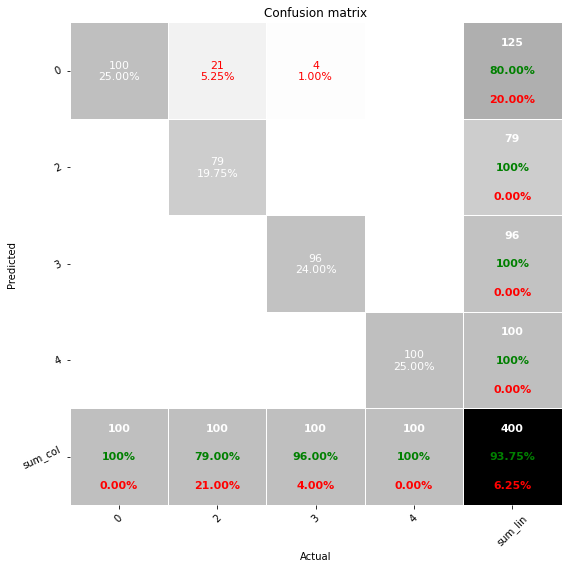

              precision    recall  f1-score   support

           0      0.800     1.000     0.889       100
           2      1.000     0.790     0.883       100
           3      1.000     0.960     0.980       100
           4      1.000     1.000     1.000       100

    accuracy                          0.938       400
   macro avg      0.950     0.938     0.938       400
weighted avg      0.950     0.938     0.938       400



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from pretty_confusion_matrix import pp_matrix
from sklearn.metrics import f1_score

df_label_predicted = pd.read_excel('predicted_dataset.xlsx')
label = df_label_predicted['label']
prediction = df_label_predicted['prediction']

array = confusion_matrix(label, prediction)
df_cm = pd.DataFrame(array, index = [i for i in "0234"],
                  columns = [i for i in "0234"])

pp_matrix(df_cm,cmap='binary')
print(classification_report(label, prediction,digits = 3))



## Evaluation 
We get an overall accuracy of 93.50% . Cluster 4 which is Trump related news performes the best and Cluster 0 miss classifies 26 documents. 22 from cluster 2 and 4 from cluster 3 bu classifies all the documents from its own cluster correctly.

## 6. Model Deployment using flask and docker

Open py_charm Run test script, deploy script.
